**Author:** [Riccardo Guidotti](http://kdd.isti.cnr.it/people/riccardo-guidotti)  
**Python version:**  3.x

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict

# Data Preparation

In [2]:
class_name = 'churn'
df = pd.read_csv('churn.csv', skipinitialspace=True, na_values='?', keep_default_na=True)

columns2remove = ['phone number']
df.drop(columns2remove, inplace=True, axis=1)
df.head()

,state,account length,area code,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [3]:
import sys
sys.path.append('./')

In [4]:
from data_preparation import prepare_dataset

In [5]:
res = prepare_dataset(df, class_name)
df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map = res
df.head()

/Users/riccardo/Google Drive/DataMining2/Notebook/data_preparation.py:40: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  df = pd.concat([dfX, dfY], axis=1, join_axes=[dfX.index])


,account length,area code,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,...,state=VT,state=WA,state=WI,state=WV,state=WY,international plan=no,international plan=yes,voice mail plan=no,voice mail plan=yes,churn
0,128,415,25,265.1,110,45.07,197.4,99,16.78,244.7,...,0,0,0,0,0,1,0,0,1,0
1,107,415,26,161.6,123,27.47,195.5,103,16.62,254.4,...,0,0,0,0,0,1,0,0,1,0
2,137,415,0,243.4,114,41.38,121.2,110,10.30,162.6,...,0,0,0,0,0,1,0,1,0,0
3,84,408,0,299.4,71,50.90,61.9,88,5.26,196.9,...,0,0,0,0,0,0,1,1,0,0
4,75,415,0,166.7,113,28.34,148.3,122,12.61,186.9,...,0,0,0,0,0,0,1,1,0,0


# Data Partitioning

In [6]:
from sklearn.model_selection import train_test_split, cross_val_score 

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [7]:
attributes = [col for col in df.columns if col != class_name]
X = df[attributes].values
y = df[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

# Normalization

In [8]:
from sklearn.preprocessing import StandardScaler

In [9]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Sklearn Multilayer Perceptron

In [10]:
from sklearn.neural_network import MLPClassifier

### Parameters

hidden_layer_sizes tuple, length = n_layers - 2, default=(100,)
The ith element represents the number of neurons in the ith hidden layer.

activation {'identity', 'logistic', 'tanh', 'relu'}, default='relu'
Activation function for the hidden layer.
* 'identity', no-op activation, useful to implement linear bottleneck, returns f(x) = x
* 'logistic', the logistic sigmoid function, returns f(x) = 1 / (1 + exp(-x)).
* 'tanh', the hyperbolic tan function, returns f(x) = tanh(x).
* 'relu', the rectified linear unit function, returns f(x) = max(0, x)

solver {'lbfgs', 'sgd', 'adam'}, default='adam'
The solver for weight optimization.
* 'lbfgs' is an optimizer in the family of quasi-Newton methods.
* 'sgd' refers to stochastic gradient descent.
* 'adam' refers to a stochastic gradient-based optimizer proposed by Kingma, Diederik, and Jimmy Ba
The default solver 'adam' works pretty well on relatively large datasets (>= 1000 training samples) in terms of both training time and validation score. For small datasets, 'lbfgs' can converge faster and perform better.

alpha float, default=0.0001
L2 penalty (regularization term) parameter.

batch_size int, default='auto'
Size of minibatches for stochastic optimizers. If the solver is 'lbfgs', the classifier will not use minibatch. When set to “auto”, batch_size=min(200, n_samples)

learning_rate {'constant', 'invscaling', 'adaptive'}, default='constant'
Learning rate schedule for weight updates.
*'constant' is a constant learning rate given by 'learning_rate_init'.
*'invscaling' gradually decreases the learning rate at each time step 't' using an inverse scaling exponent of *'power_t'. effective_learning_rate = learning_rate_init / pow(t, power_t)
*'adaptive' keeps the learning rate constant to 'learning_rate_init' as long as training loss keeps decreasing. Each time two consecutive epochs fail to decrease training loss by at least tol, or fail to increase validation score by at least tol if 'early_stopping' is on, the current learning rate is divided by 5.
Only used when solver='sgd'.

learning_rate_init double, default=0.001
The initial learning rate used. It controls the step-size in updating the weights. Only used when solver='sgd' or 'adam'.

power_t double, default=0.5
The exponent for inverse scaling learning rate. It is used in updating effective learning rate when the learning_rate is set to 'invscaling'. Only used when solver='sgd'.

max_iter int, default=200
Maximum number of iterations. The solver iterates until convergence (determined by 'tol') or this number of iterations. For stochastic solvers ('sgd', 'adam'), note that this determines the number of epochs (how many times each data point will be used), not the number of gradient steps.

shuffle bool, default=True
Whether to shuffle samples in each iteration. Only used when solver='sgd' or 'adam'.

random_state int, RandomState instance or None, default=None
If int, random_state is the seed used by the random number generator; If RandomState instance, random_state is the random number generator; If None, the random number generator is the RandomState instance used by np.random.

tol float, default=1e-4
Tolerance for the optimization. When the loss or score is not improving by at least tol for n_iter_no_change consecutive iterations, unless learning_rate is set to 'adaptive', convergence is considered to be reached and training stops.

verbose bool, default=False
Whether to print progress messages to stdout.

warm_start bool, default=False
When set to True, reuse the solution of the previous call to fit as initialization, otherwise, just erase the previous solution. See the Glossary.

momentum float, default=0.9
Momentum for gradient descent update. Should be between 0 and 1. Only used when solver='sgd'.

early_stopping bool, default=False
Whether to use early stopping to terminate training when validation score is not improving. If set to true, it will automatically set aside 10% of training data as validation and terminate training when validation score is not improving by at least tol for n_iter_no_change consecutive epochs. The split is stratified, except in a multilabel setting. Only effective when solver='sgd' or 'adam'

validation_fraction float, default=0.1
The proportion of training data to set aside as validation set for early stopping. Must be between 0 and 1. Only used if early_stopping is True

beta_1 float, default=0.9
Exponential decay rate for estimates of first moment vector in adam, should be in [0, 1). Only used when solver='adam'

beta_2 float, default=0.999
Exponential decay rate for estimates of second moment vector in adam, should be in [0, 1). Only used when solver='adam'

epsilon float, default=1e-8
Value for numerical stability in adam. Only used when solver='adam'

n_iter_no_change int, default=10
Maximum number of epochs to not meet tol improvement. Only effective when solver='sgd' or 'adam'


### Attributes
loss_ float
The current loss computed with the loss function.

coefs_ list, length n_layers - 1
The ith element in the list represents the weight matrix corresponding to layer i.

intercepts_ list, length n_layers - 1
The ith element in the list represents the bias vector corresponding to layer i + 1.

n_iter_ int,
The number of iterations the solver has ran.

n_layers_ int
Number of layers.

n_outputs_ int
Number of outputs.

out_activation_ string
Name of the output activation function.

In [11]:
clf = MLPClassifier(random_state=0)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.887
F1-score [0.93471982 0.57992565]
              precision    recall  f1-score   support

           0       0.92      0.95      0.93       855
           1       0.63      0.54      0.58       145

    accuracy                           0.89      1000
   macro avg       0.78      0.74      0.76      1000
weighted avg       0.88      0.89      0.88      1000



/Users/riccardo/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


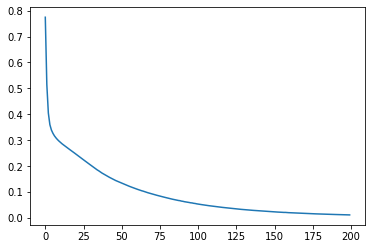

In [12]:
plt.plot(clf.loss_curve_)
plt.show()

In [13]:
clf = MLPClassifier(hidden_layer_sizes=(128, 64, 32,), alpha=0.1, learning_rate='adaptive', 
                    activation='tanh', early_stopping=False, momentum=0.9, random_state=0)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.896
F1-score [0.93974508 0.62043796]
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       855
           1       0.66      0.59      0.62       145

    accuracy                           0.90      1000
   macro avg       0.80      0.77      0.78      1000
weighted avg       0.89      0.90      0.89      1000



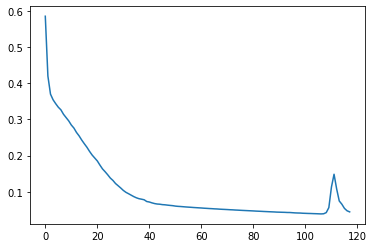

In [65]:
plt.plot(clf.loss_curve_)
plt.show()

In [14]:
params = [{'solver': 'sgd', 'learning_rate': 'constant', 'momentum': 0,'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'constant', 'momentum': .9,
           'nesterovs_momentum': False, 'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'invscaling', 'momentum': 0,
           'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'invscaling', 'momentum': .9,
           'nesterovs_momentum': False, 'learning_rate_init': 0.2},
          {'solver': 'adam', 'learning_rate_init': 0.01}]

labels = ["constant learning-rate", "constant with momentum",
          "inv-scaling learning-rate", "inv-scaling with momentum", "adam"]

In [15]:
import warnings
from sklearn.exceptions import ConvergenceWarning

constant learning-rate
training set score and loss: 0.855, 0.967356


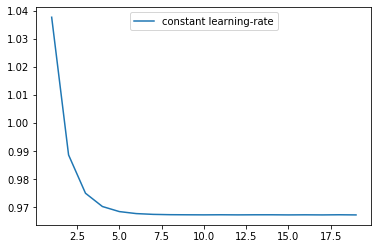

constant with momentum
training set score and loss: 0.855, 13524.163578


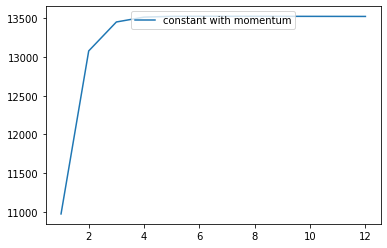

inv-scaling learning-rate
training set score and loss: 0.855, 1.033817


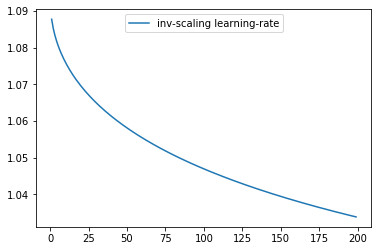

inv-scaling with momentum
training set score and loss: 0.855, 13529.265608


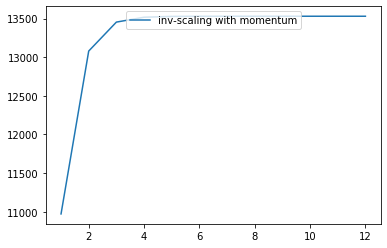

adam
training set score and loss: 0.899, 0.323044


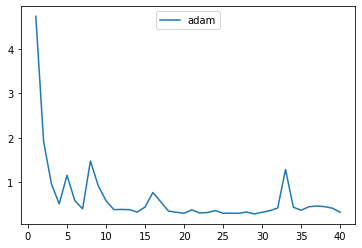

In [16]:
for label, param in zip(labels, params):
    print(label)
    clf = MLPClassifier(random_state=0, max_iter=200, **param)

    # some parameter combinations will not converge as can be seen on the
    # plots so they are ignored here
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
        clf.fit(X, y)

    print("training set score and loss: %.3f, %f" % (clf.score(X, y), clf.loss_))
    plt.plot(clf.loss_curve_, label=label)
    plt.legend(loc="upper center")
    plt.show()

# Keras Deep Neural Networks

In [17]:
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [18]:
def build_model():
    
    n_feature = X_train.shape[1]
    model = Sequential()
    model.add(Dense(128, input_dim=n_feature, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [19]:
model1 = build_model()

history1 = model1.fit(X_train, y_train, epochs=50, batch_size=10).history

Epoch 1/50
2333/2333 [==============================] - 1s 491us/step - loss: 0.3696 - accuracy: 0.8633
Epoch 2/50
2333/2333 [==============================] - 1s 220us/step - loss: 0.2968 - accuracy: 0.8860
Epoch 3/50
2333/2333 [==============================] - 1s 219us/step - loss: 0.2475 - accuracy: 0.9014
Epoch 4/50
2333/2333 [==============================] - 1s 216us/step - loss: 0.1971 - accuracy: 0.9280
Epoch 5/50
2333/2333 [==============================] - 1s 227us/step - loss: 0.1675 - accuracy: 0.9400
Epoch 6/50
2333/2333 [==============================] - 1s 232us/step - loss: 0.1440 - accuracy: 0.9507
Epoch 7/50
2333/2333 [==============================] - 1s 223us/step - loss: 0.1202 - accuracy: 0.9593
Epoch 8/50
2333/2333 [==============================] - 1s 226us/step - loss: 0.0986 - accuracy: 0.9709
Epoch 9/50
2333/2333 [==============================] - 1s 228us/step - loss: 0.0869 - accuracy: 0.9687
Epoch 10/50
2333/2333 [==============================] - 1s 225u

In [20]:
model2 = build_model()

history2 = model2.fit(X_train, y_train, epochs=50, batch_size=50).history

Epoch 1/50
2333/2333 [==============================] - 1s 300us/step - loss: 0.4063 - accuracy: 0.8491
Epoch 2/50
2333/2333 [==============================] - 0s 54us/step - loss: 0.3176 - accuracy: 0.8706
Epoch 3/50
2333/2333 [==============================] - 0s 53us/step - loss: 0.2826 - accuracy: 0.8868
Epoch 4/50
2333/2333 [==============================] - 0s 52us/step - loss: 0.2533 - accuracy: 0.9018
Epoch 5/50
2333/2333 [==============================] - 0s 55us/step - loss: 0.2240 - accuracy: 0.9194
Epoch 6/50
2333/2333 [==============================] - 0s 54us/step - loss: 0.1942 - accuracy: 0.9344
Epoch 7/50
2333/2333 [==============================] - 0s 52us/step - loss: 0.1736 - accuracy: 0.9400
Epoch 8/50
2333/2333 [==============================] - 0s 53us/step - loss: 0.1543 - accuracy: 0.9503
Epoch 9/50
2333/2333 [==============================] - 0s 52us/step - loss: 0.1405 - accuracy: 0.9529
Epoch 10/50
2333/2333 [==============================] - 0s 52us/step - 

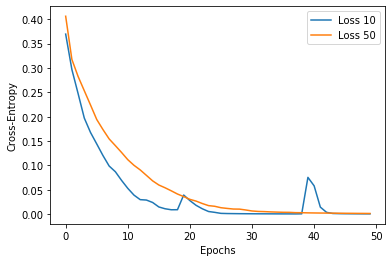

In [21]:
plt.plot(history1['loss'], label='Loss 10')
plt.plot(history2['loss'], label='Loss 50')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.show()

In [22]:
test_loss_1, test_acc_1 = model1.evaluate(X_test, y_test)
test_loss_2, test_acc_2 = model2.evaluate(X_test, y_test)

print('Loss %f, Accuracy %f' % (test_loss_1, test_acc_1))
print('Loss %f, Accuracy %f' % (test_loss_2, test_acc_2))

1000/1000 [==============================] - 0s 165us/step
Loss 0.782997, Accuracy 0.891000
Loss 0.711365, Accuracy 0.874000


In [23]:
y_pred = model1.predict(X_test).astype(int)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.868
F1-score [0.92833876 0.16455696]
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       855
           1       1.00      0.09      0.16       145

    accuracy                           0.87      1000
   macro avg       0.93      0.54      0.55      1000
weighted avg       0.89      0.87      0.82      1000



In [24]:
model3 = build_model()

history3 = model3.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1000, batch_size=10).history

Train on 2333 samples, validate on 1000 samples
Epoch 1/1000
2333/2333 [==============================] - 1s 559us/step - loss: 0.3820 - accuracy: 0.8478 - val_loss: 0.3522 - val_accuracy: 0.8630
Epoch 2/1000
2333/2333 [==============================] - 1s 283us/step - loss: 0.2989 - accuracy: 0.8770 - val_loss: 0.3185 - val_accuracy: 0.8630
Epoch 3/1000
2333/2333 [==============================] - 1s 294us/step - loss: 0.2466 - accuracy: 0.9057 - val_loss: 0.2746 - val_accuracy: 0.8850
Epoch 4/1000
2333/2333 [==============================] - 1s 318us/step - loss: 0.2028 - accuracy: 0.9211 - val_loss: 0.2604 - val_accuracy: 0.9000
Epoch 5/1000
2333/2333 [==============================] - 1s 333us/step - loss: 0.1680 - accuracy: 0.9374 - val_loss: 0.2734 - val_accuracy: 0.8910
Epoch 6/1000
2333/2333 [==============================] - 1s 326us/step - loss: 0.1411 - accuracy: 0.9520 - val_loss: 0.2780 - val_accuracy: 0.8920
Epoch 7/1000
2333/2333 [==============================] - 1s 324

2333/2333 [==============================] - 1s 317us/step - loss: 3.3414e-04 - accuracy: 1.0000 - val_loss: 0.8002 - val_accuracy: 0.8950
Epoch 56/1000
2333/2333 [==============================] - 1s 313us/step - loss: 2.9050e-04 - accuracy: 1.0000 - val_loss: 0.8087 - val_accuracy: 0.8970
Epoch 57/1000
2333/2333 [==============================] - 1s 306us/step - loss: 2.5183e-04 - accuracy: 1.0000 - val_loss: 0.8217 - val_accuracy: 0.8950
Epoch 58/1000
2333/2333 [==============================] - 1s 312us/step - loss: 2.2054e-04 - accuracy: 1.0000 - val_loss: 0.8287 - val_accuracy: 0.8950
Epoch 59/1000
2333/2333 [==============================] - 1s 309us/step - loss: 1.9280e-04 - accuracy: 1.0000 - val_loss: 0.8398 - val_accuracy: 0.8960
Epoch 60/1000
2333/2333 [==============================] - 1s 310us/step - loss: 1.6906e-04 - accuracy: 1.0000 - val_loss: 0.8505 - val_accuracy: 0.8970
Epoch 61/1000
2333/2333 [==============================] - 1s 328us/step - loss: 1.4920e-04 - ac

Epoch 109/1000
2333/2333 [==============================] - 1s 303us/step - loss: 2.7253e-05 - accuracy: 1.0000 - val_loss: 1.0108 - val_accuracy: 0.8910
Epoch 110/1000
2333/2333 [==============================] - 1s 302us/step - loss: 2.4671e-05 - accuracy: 1.0000 - val_loss: 1.0180 - val_accuracy: 0.8890
Epoch 111/1000
2333/2333 [==============================] - 1s 303us/step - loss: 2.2251e-05 - accuracy: 1.0000 - val_loss: 1.0267 - val_accuracy: 0.8890
Epoch 112/1000
2333/2333 [==============================] - 1s 303us/step - loss: 1.9994e-05 - accuracy: 1.0000 - val_loss: 1.0367 - val_accuracy: 0.8900
Epoch 113/1000
2333/2333 [==============================] - 1s 312us/step - loss: 1.8133e-05 - accuracy: 1.0000 - val_loss: 1.0452 - val_accuracy: 0.8900
Epoch 114/1000
2333/2333 [==============================] - 1s 312us/step - loss: 1.6175e-05 - accuracy: 1.0000 - val_loss: 1.0536 - val_accuracy: 0.8880
Epoch 115/1000
2333/2333 [==============================] - 1s 313us/step - 

2333/2333 [==============================] - 1s 304us/step - loss: 1.9930e-05 - accuracy: 1.0000 - val_loss: 1.1044 - val_accuracy: 0.8910
Epoch 163/1000
2333/2333 [==============================] - 1s 307us/step - loss: 1.8044e-05 - accuracy: 1.0000 - val_loss: 1.1107 - val_accuracy: 0.8920
Epoch 164/1000
2333/2333 [==============================] - 1s 313us/step - loss: 1.6398e-05 - accuracy: 1.0000 - val_loss: 1.1169 - val_accuracy: 0.8920
Epoch 165/1000
2333/2333 [==============================] - 1s 314us/step - loss: 1.4921e-05 - accuracy: 1.0000 - val_loss: 1.1232 - val_accuracy: 0.8920
Epoch 166/1000
2333/2333 [==============================] - 1s 313us/step - loss: 1.3457e-05 - accuracy: 1.0000 - val_loss: 1.1314 - val_accuracy: 0.8930
Epoch 167/1000
2333/2333 [==============================] - 1s 358us/step - loss: 1.2220e-05 - accuracy: 1.0000 - val_loss: 1.1383 - val_accuracy: 0.8920
Epoch 168/1000
2333/2333 [==============================] - 1s 313us/step - loss: 1.1066e-0

2333/2333 [==============================] - 1s 321us/step - loss: 4.0417e-08 - accuracy: 1.0000 - val_loss: 1.7141 - val_accuracy: 0.8890
Epoch 216/1000
2333/2333 [==============================] - 1s 318us/step - loss: 3.6357e-08 - accuracy: 1.0000 - val_loss: 1.7276 - val_accuracy: 0.8890
Epoch 217/1000
2333/2333 [==============================] - 1s 322us/step - loss: 3.2721e-08 - accuracy: 1.0000 - val_loss: 1.7376 - val_accuracy: 0.8890
Epoch 218/1000
2333/2333 [==============================] - 1s 328us/step - loss: 2.8908e-08 - accuracy: 1.0000 - val_loss: 1.7459 - val_accuracy: 0.8880
Epoch 219/1000
2333/2333 [==============================] - 1s 328us/step - loss: 2.6036e-08 - accuracy: 1.0000 - val_loss: 1.7571 - val_accuracy: 0.8860
Epoch 220/1000
2333/2333 [==============================] - 1s 330us/step - loss: 2.3516e-08 - accuracy: 1.0000 - val_loss: 1.7707 - val_accuracy: 0.8880
Epoch 221/1000
2333/2333 [==============================] - 1s 308us/step - loss: 2.0883e-0

2333/2333 [==============================] - 1s 306us/step - loss: 1.6792e-09 - accuracy: 1.0000 - val_loss: 2.0690 - val_accuracy: 0.8890
Epoch 269/1000
2333/2333 [==============================] - 1s 302us/step - loss: 1.7003e-09 - accuracy: 1.0000 - val_loss: 2.0683 - val_accuracy: 0.8890
Epoch 270/1000
2333/2333 [==============================] - 1s 313us/step - loss: 1.5946e-09 - accuracy: 1.0000 - val_loss: 2.0721 - val_accuracy: 0.8890
Epoch 271/1000
2333/2333 [==============================] - 1s 301us/step - loss: 1.5910e-09 - accuracy: 1.0000 - val_loss: 2.0784 - val_accuracy: 0.8880
Epoch 272/1000
2333/2333 [==============================] - 1s 308us/step - loss: 1.5754e-09 - accuracy: 1.0000 - val_loss: 2.0809 - val_accuracy: 0.8880
Epoch 273/1000
2333/2333 [==============================] - 1s 306us/step - loss: 1.6339e-09 - accuracy: 1.0000 - val_loss: 2.0823 - val_accuracy: 0.8880
Epoch 274/1000
2333/2333 [==============================] - 1s 303us/step - loss: 1.5005e-0

2333/2333 [==============================] - 1s 303us/step - loss: 1.2542e-09 - accuracy: 1.0000 - val_loss: 2.1418 - val_accuracy: 0.8890
Epoch 322/1000
2333/2333 [==============================] - 1s 302us/step - loss: 1.1973e-09 - accuracy: 1.0000 - val_loss: 2.1447 - val_accuracy: 0.8890
Epoch 323/1000
2333/2333 [==============================] - 1s 304us/step - loss: 1.2953e-09 - accuracy: 1.0000 - val_loss: 2.1477 - val_accuracy: 0.8890
Epoch 324/1000
2333/2333 [==============================] - 1s 302us/step - loss: 1.3377e-09 - accuracy: 1.0000 - val_loss: 2.1420 - val_accuracy: 0.8890
Epoch 325/1000
2333/2333 [==============================] - 1s 301us/step - loss: 1.2962e-09 - accuracy: 1.0000 - val_loss: 2.1441 - val_accuracy: 0.8890
Epoch 326/1000
2333/2333 [==============================] - 1s 310us/step - loss: 1.3256e-09 - accuracy: 1.0000 - val_loss: 2.1466 - val_accuracy: 0.8890
Epoch 327/1000
2333/2333 [==============================] - 1s 312us/step - loss: 1.3845e-0

2333/2333 [==============================] - 1s 343us/step - loss: 1.3035e-09 - accuracy: 1.0000 - val_loss: 2.1779 - val_accuracy: 0.8910
Epoch 375/1000
2333/2333 [==============================] - 1s 346us/step - loss: 1.2736e-09 - accuracy: 1.0000 - val_loss: 2.1799 - val_accuracy: 0.8910
Epoch 376/1000
2333/2333 [==============================] - 1s 348us/step - loss: 1.2442e-09 - accuracy: 1.0000 - val_loss: 2.1810 - val_accuracy: 0.8910
Epoch 377/1000
2333/2333 [==============================] - 1s 343us/step - loss: 1.1902e-09 - accuracy: 1.0000 - val_loss: 2.1787 - val_accuracy: 0.8910
Epoch 378/1000
2333/2333 [==============================] - 1s 344us/step - loss: 1.1920e-09 - accuracy: 1.0000 - val_loss: 2.1814 - val_accuracy: 0.8910
Epoch 379/1000
2333/2333 [==============================] - 1s 361us/step - loss: 1.1828e-09 - accuracy: 1.0000 - val_loss: 2.1837 - val_accuracy: 0.8910
Epoch 380/1000
2333/2333 [==============================] - 1s 326us/step - loss: 1.2433e-0

2333/2333 [==============================] - 1s 304us/step - loss: 1.3332e-09 - accuracy: 1.0000 - val_loss: 2.2024 - val_accuracy: 0.8930
Epoch 428/1000
2333/2333 [==============================] - 1s 303us/step - loss: 1.3629e-09 - accuracy: 1.0000 - val_loss: 2.2007 - val_accuracy: 0.8930
Epoch 429/1000
2333/2333 [==============================] - 1s 302us/step - loss: 1.3315e-09 - accuracy: 1.0000 - val_loss: 2.2019 - val_accuracy: 0.8930
Epoch 430/1000
2333/2333 [==============================] - 1s 300us/step - loss: 1.3772e-09 - accuracy: 1.0000 - val_loss: 2.2030 - val_accuracy: 0.8930
Epoch 431/1000
2333/2333 [==============================] - 1s 302us/step - loss: 1.3861e-09 - accuracy: 1.0000 - val_loss: 2.2032 - val_accuracy: 0.8930
Epoch 432/1000
2333/2333 [==============================] - 1s 305us/step - loss: 1.3072e-09 - accuracy: 1.0000 - val_loss: 2.2036 - val_accuracy: 0.8920
Epoch 433/1000
2333/2333 [==============================] - 1s 301us/step - loss: 1.2791e-0

2333/2333 [==============================] - 1s 303us/step - loss: 1.2134e-09 - accuracy: 1.0000 - val_loss: 2.2091 - val_accuracy: 0.8910
Epoch 481/1000
2333/2333 [==============================] - 1s 308us/step - loss: 1.2111e-09 - accuracy: 1.0000 - val_loss: 2.2102 - val_accuracy: 0.8910
Epoch 482/1000
2333/2333 [==============================] - 1s 302us/step - loss: 1.2114e-09 - accuracy: 1.0000 - val_loss: 2.2103 - val_accuracy: 0.8910
Epoch 483/1000
2333/2333 [==============================] - 1s 302us/step - loss: 1.2050e-09 - accuracy: 1.0000 - val_loss: 2.2113 - val_accuracy: 0.8910
Epoch 484/1000
2333/2333 [==============================] - 1s 302us/step - loss: 1.2429e-09 - accuracy: 1.0000 - val_loss: 2.2123 - val_accuracy: 0.8920
Epoch 485/1000
2333/2333 [==============================] - 1s 302us/step - loss: 1.2536e-09 - accuracy: 1.0000 - val_loss: 2.2135 - val_accuracy: 0.8920
Epoch 486/1000
2333/2333 [==============================] - 1s 300us/step - loss: 1.1997e-0

2333/2333 [==============================] - 1s 358us/step - loss: 1.2908e-09 - accuracy: 1.0000 - val_loss: 2.2221 - val_accuracy: 0.8910
Epoch 534/1000
2333/2333 [==============================] - 1s 347us/step - loss: 1.2952e-09 - accuracy: 1.0000 - val_loss: 2.2228 - val_accuracy: 0.8910
Epoch 535/1000
2333/2333 [==============================] - 1s 347us/step - loss: 1.3231e-09 - accuracy: 1.0000 - val_loss: 2.2236 - val_accuracy: 0.8910
Epoch 536/1000
2333/2333 [==============================] - 1s 327us/step - loss: 1.2371e-09 - accuracy: 1.0000 - val_loss: 2.2206 - val_accuracy: 0.8900
Epoch 537/1000
2333/2333 [==============================] - 1s 307us/step - loss: 1.1609e-09 - accuracy: 1.0000 - val_loss: 2.2215 - val_accuracy: 0.8910
Epoch 538/1000
2333/2333 [==============================] - 1s 301us/step - loss: 1.1871e-09 - accuracy: 1.0000 - val_loss: 2.2223 - val_accuracy: 0.8910
Epoch 539/1000
2333/2333 [==============================] - 1s 308us/step - loss: 1.2088e-0

2333/2333 [==============================] - 1s 334us/step - loss: 1.1338e-09 - accuracy: 1.0000 - val_loss: 2.2300 - val_accuracy: 0.8930
Epoch 587/1000
2333/2333 [==============================] - 1s 312us/step - loss: 1.1206e-09 - accuracy: 1.0000 - val_loss: 2.2308 - val_accuracy: 0.8930
Epoch 588/1000
2333/2333 [==============================] - 1s 311us/step - loss: 1.1116e-09 - accuracy: 1.0000 - val_loss: 2.2297 - val_accuracy: 0.8930
Epoch 589/1000
2333/2333 [==============================] - 1s 302us/step - loss: 1.0711e-09 - accuracy: 1.0000 - val_loss: 2.2305 - val_accuracy: 0.8930
Epoch 590/1000
2333/2333 [==============================] - 1s 299us/step - loss: 1.0982e-09 - accuracy: 1.0000 - val_loss: 2.2313 - val_accuracy: 0.8930
Epoch 591/1000
2333/2333 [==============================] - 1s 300us/step - loss: 1.1220e-09 - accuracy: 1.0000 - val_loss: 2.2321 - val_accuracy: 0.8930
Epoch 592/1000
2333/2333 [==============================] - 1s 300us/step - loss: 1.1472e-0

2333/2333 [==============================] - 1s 320us/step - loss: 1.2870e-09 - accuracy: 1.0000 - val_loss: 2.2430 - val_accuracy: 0.8930
Epoch 640/1000
2333/2333 [==============================] - 1s 329us/step - loss: 1.2830e-09 - accuracy: 1.0000 - val_loss: 2.2439 - val_accuracy: 0.8930
Epoch 641/1000
2333/2333 [==============================] - 1s 338us/step - loss: 1.2463e-09 - accuracy: 1.0000 - val_loss: 2.2445 - val_accuracy: 0.8930
Epoch 642/1000
2333/2333 [==============================] - 1s 305us/step - loss: 1.2663e-09 - accuracy: 1.0000 - val_loss: 2.2451 - val_accuracy: 0.8930
Epoch 643/1000
2333/2333 [==============================] - 1s 311us/step - loss: 1.2738e-09 - accuracy: 1.0000 - val_loss: 2.2447 - val_accuracy: 0.8930
Epoch 644/1000
2333/2333 [==============================] - 1s 305us/step - loss: 1.2308e-09 - accuracy: 1.0000 - val_loss: 2.2453 - val_accuracy: 0.8930
Epoch 645/1000
2333/2333 [==============================] - 1s 304us/step - loss: 1.2529e-0

2333/2333 [==============================] - 1s 309us/step - loss: 1.1427e-09 - accuracy: 1.0000 - val_loss: 2.2481 - val_accuracy: 0.8920
Epoch 693/1000
2333/2333 [==============================] - 1s 303us/step - loss: 1.1405e-09 - accuracy: 1.0000 - val_loss: 2.2487 - val_accuracy: 0.8920
Epoch 694/1000
2333/2333 [==============================] - 1s 317us/step - loss: 1.1508e-09 - accuracy: 1.0000 - val_loss: 2.2488 - val_accuracy: 0.8920
Epoch 695/1000
2333/2333 [==============================] - 1s 327us/step - loss: 1.1284e-09 - accuracy: 1.0000 - val_loss: 2.2494 - val_accuracy: 0.8920
Epoch 696/1000
2333/2333 [==============================] - 1s 335us/step - loss: 1.1457e-09 - accuracy: 1.0000 - val_loss: 2.2499 - val_accuracy: 0.8920
Epoch 697/1000
2333/2333 [==============================] - 1s 321us/step - loss: 1.1635e-09 - accuracy: 1.0000 - val_loss: 2.2504 - val_accuracy: 0.8920
Epoch 698/1000
2333/2333 [==============================] - 1s 313us/step - loss: 1.1824e-0

2333/2333 [==============================] - 1s 307us/step - loss: 1.2515e-09 - accuracy: 1.0000 - val_loss: 2.2619 - val_accuracy: 0.8920
Epoch 746/1000
2333/2333 [==============================] - 1s 315us/step - loss: 1.2686e-09 - accuracy: 1.0000 - val_loss: 2.2624 - val_accuracy: 0.8920
Epoch 747/1000
2333/2333 [==============================] - 1s 309us/step - loss: 1.2828e-09 - accuracy: 1.0000 - val_loss: 2.2600 - val_accuracy: 0.8910
Epoch 748/1000
2333/2333 [==============================] - 1s 314us/step - loss: 1.1878e-09 - accuracy: 1.0000 - val_loss: 2.2595 - val_accuracy: 0.8910
Epoch 749/1000
2333/2333 [==============================] - 1s 302us/step - loss: 1.0829e-09 - accuracy: 1.0000 - val_loss: 2.2600 - val_accuracy: 0.8910
Epoch 750/1000
2333/2333 [==============================] - 1s 306us/step - loss: 1.1005e-09 - accuracy: 1.0000 - val_loss: 2.2605 - val_accuracy: 0.8910
Epoch 751/1000
2333/2333 [==============================] - 1s 313us/step - loss: 1.1163e-0

2333/2333 [==============================] - 1s 310us/step - loss: 1.1243e-09 - accuracy: 1.0000 - val_loss: 2.2598 - val_accuracy: 0.8930
Epoch 799/1000
2333/2333 [==============================] - 1s 309us/step - loss: 1.1137e-09 - accuracy: 1.0000 - val_loss: 2.2603 - val_accuracy: 0.8930
Epoch 800/1000
2333/2333 [==============================] - 1s 316us/step - loss: 1.1288e-09 - accuracy: 1.0000 - val_loss: 2.2608 - val_accuracy: 0.8930
Epoch 801/1000
2333/2333 [==============================] - 1s 325us/step - loss: 1.1424e-09 - accuracy: 1.0000 - val_loss: 2.2612 - val_accuracy: 0.8930
Epoch 802/1000
2333/2333 [==============================] - 1s 329us/step - loss: 1.1160e-09 - accuracy: 1.0000 - val_loss: 2.2582 - val_accuracy: 0.8930
Epoch 803/1000
2333/2333 [==============================] - 1s 356us/step - loss: 1.1063e-09 - accuracy: 1.0000 - val_loss: 2.2587 - val_accuracy: 0.8930
Epoch 804/1000
2333/2333 [==============================] - 1s 312us/step - loss: 1.1193e-0

2333/2333 [==============================] - 1s 311us/step - loss: 1.1484e-09 - accuracy: 1.0000 - val_loss: 2.2704 - val_accuracy: 0.8930
Epoch 852/1000
2333/2333 [==============================] - 1s 305us/step - loss: 1.1623e-09 - accuracy: 1.0000 - val_loss: 2.2708 - val_accuracy: 0.8930
Epoch 853/1000
2333/2333 [==============================] - 1s 314us/step - loss: 1.1761e-09 - accuracy: 1.0000 - val_loss: 2.2712 - val_accuracy: 0.8930
Epoch 854/1000
2333/2333 [==============================] - 1s 317us/step - loss: 1.1881e-09 - accuracy: 1.0000 - val_loss: 2.2716 - val_accuracy: 0.8930
Epoch 855/1000
2333/2333 [==============================] - 1s 321us/step - loss: 1.2022e-09 - accuracy: 1.0000 - val_loss: 2.2719 - val_accuracy: 0.8930
Epoch 856/1000
2333/2333 [==============================] - 1s 314us/step - loss: 1.2148e-09 - accuracy: 1.0000 - val_loss: 2.2723 - val_accuracy: 0.8930
Epoch 857/1000
2333/2333 [==============================] - 1s 308us/step - loss: 1.2282e-0

2333/2333 [==============================] - 1s 306us/step - loss: 1.1759e-09 - accuracy: 1.0000 - val_loss: 2.2714 - val_accuracy: 0.8930
Epoch 905/1000
2333/2333 [==============================] - 1s 311us/step - loss: 1.1888e-09 - accuracy: 1.0000 - val_loss: 2.2718 - val_accuracy: 0.8930
Epoch 906/1000
2333/2333 [==============================] - 1s 311us/step - loss: 1.2005e-09 - accuracy: 1.0000 - val_loss: 2.2721 - val_accuracy: 0.8930
Epoch 907/1000
2333/2333 [==============================] - 1s 313us/step - loss: 1.1868e-09 - accuracy: 1.0000 - val_loss: 2.2700 - val_accuracy: 0.8930
Epoch 908/1000
2333/2333 [==============================] - 1s 308us/step - loss: 1.1534e-09 - accuracy: 1.0000 - val_loss: 2.2704 - val_accuracy: 0.8930
Epoch 909/1000
2333/2333 [==============================] - 1s 305us/step - loss: 1.1652e-09 - accuracy: 1.0000 - val_loss: 2.2707 - val_accuracy: 0.8930
Epoch 910/1000
2333/2333 [==============================] - 1s 304us/step - loss: 1.1781e-0

2333/2333 [==============================] - 1s 315us/step - loss: 1.0809e-09 - accuracy: 1.0000 - val_loss: 2.2771 - val_accuracy: 0.8930
Epoch 958/1000
2333/2333 [==============================] - 1s 302us/step - loss: 1.0937e-09 - accuracy: 1.0000 - val_loss: 2.2775 - val_accuracy: 0.8930
Epoch 959/1000
2333/2333 [==============================] - 1s 303us/step - loss: 1.1043e-09 - accuracy: 1.0000 - val_loss: 2.2778 - val_accuracy: 0.8930
Epoch 960/1000
2333/2333 [==============================] - 1s 305us/step - loss: 1.1177e-09 - accuracy: 1.0000 - val_loss: 2.2782 - val_accuracy: 0.8930
Epoch 961/1000
2333/2333 [==============================] - 1s 308us/step - loss: 1.1302e-09 - accuracy: 1.0000 - val_loss: 2.2786 - val_accuracy: 0.8930
Epoch 962/1000
2333/2333 [==============================] - 1s 346us/step - loss: 1.1150e-09 - accuracy: 1.0000 - val_loss: 2.2783 - val_accuracy: 0.8930
Epoch 963/1000
2333/2333 [==============================] - 1s 310us/step - loss: 1.0807e-0

In [25]:
test_loss_3, test_acc_3 = model3.evaluate(X_test, y_test)

print('Loss %f, Accuracy %f' % (test_loss_1, test_acc_1))
print('Loss %f, Accuracy %f' % (test_loss_2, test_acc_2))
print('Loss %f, Accuracy %f' % (test_loss_3, test_acc_3))

1000/1000 [==============================] - 0s 33us/step
Loss 0.782997, Accuracy 0.891000
Loss 0.711365, Accuracy 0.874000
Loss 2.282766, Accuracy 0.893000


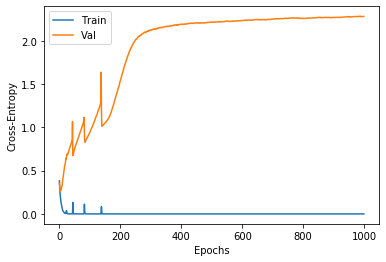

In [26]:
plt.plot(history3['loss'], label='Train')
plt.plot(history3['val_loss'], label='Val')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.show()

In [27]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

## Early Stopping

In [28]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

The most relevant arguments are:

* monitor: quantity to be monitored
* patience: number of epochs with no improvement after which training will be stopped

In [29]:
es = EarlyStopping(monitor='val_loss', patience=10)
mc = ModelCheckpoint('best_model_NOREG.h5', monitor='val_loss', save_best_only=True)

model4 = build_model()
history4 = model4.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, 
                      batch_size=10, callbacks=[es,mc]).history

Train on 1866 samples, validate on 467 samples
Epoch 1/100
1866/1866 [==============================] - 1s 706us/step - loss: 0.3775 - accuracy: 0.8558 - val_loss: 0.3435 - val_accuracy: 0.8544
Epoch 2/100
1866/1866 [==============================] - 1s 316us/step - loss: 0.3029 - accuracy: 0.8767 - val_loss: 0.3274 - val_accuracy: 0.8630
Epoch 3/100
1866/1866 [==============================] - 1s 284us/step - loss: 0.2475 - accuracy: 0.9019 - val_loss: 0.2940 - val_accuracy: 0.8865
Epoch 4/100
1866/1866 [==============================] - 1s 315us/step - loss: 0.1988 - accuracy: 0.9218 - val_loss: 0.2940 - val_accuracy: 0.8844
Epoch 5/100
1866/1866 [==============================] - 1s 311us/step - loss: 0.1607 - accuracy: 0.9421 - val_loss: 0.3053 - val_accuracy: 0.8951
Epoch 6/100
1866/1866 [==============================] - 1s 299us/step - loss: 0.1388 - accuracy: 0.9512 - val_loss: 0.3149 - val_accuracy: 0.8908
Epoch 7/100
1866/1866 [==============================] - 1s 290us/step 

In [30]:
test_loss_4, test_acc_4 = model4.evaluate(X_test, y_test)

print('Loss %f, Accuracy %f' % (test_loss_1, test_acc_1))
print('Loss %f, Accuracy %f' % (test_loss_2, test_acc_2))
print('Loss %f, Accuracy %f' % (test_loss_3, test_acc_3))
print('Loss %f, Accuracy %f' % (test_loss_4, test_acc_4))

1000/1000 [==============================] - 0s 31us/step
Loss 0.782997, Accuracy 0.891000
Loss 0.711365, Accuracy 0.874000
Loss 2.282766, Accuracy 0.893000
Loss 0.477509, Accuracy 0.887000


## L2 Regularization

In [31]:
from keras.regularizers import l2

def build_L2_model():
    # define the model
    model = Sequential()

    n_feature = X_train.shape[1]
    h_dim=100
    model.add(Dense(h_dim, activation='relu', input_shape=(n_feature,), kernel_regularizer=l2(0.01)))
    model.add(Dense(h_dim, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dense(h_dim, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dense(h_dim, activation='relu', kernel_regularizer=l2(0.01)))
    #linear activation
    model.add(Dense(1))

    #compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [32]:
mc = ModelCheckpoint('best_model_L2.h5', monitor='val_loss', save_best_only=True)

L2_model = build_L2_model()
h_L2 = L2_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, 
                    batch_size=10, callbacks=[es,mc]).history

Train on 1866 samples, validate on 467 samples
Epoch 1/100
1866/1866 [==============================] - 2s 1ms/step - loss: 3.3535 - accuracy: 0.7438 - val_loss: 2.6268 - val_accuracy: 0.8373
Epoch 2/100
1866/1866 [==============================] - 1s 441us/step - loss: 2.1949 - accuracy: 0.8596 - val_loss: 2.5128 - val_accuracy: 0.8373
Epoch 3/100
1866/1866 [==============================] - 1s 437us/step - loss: 2.1665 - accuracy: 0.8596 - val_loss: 2.5104 - val_accuracy: 0.8373
Epoch 4/100
1866/1866 [==============================] - 1s 416us/step - loss: 2.1658 - accuracy: 0.8596 - val_loss: 2.5103 - val_accuracy: 0.8373
Epoch 5/100
1866/1866 [==============================] - 1s 429us/step - loss: 2.1658 - accuracy: 0.8596 - val_loss: 2.5103 - val_accuracy: 0.8373
Epoch 6/100
1866/1866 [==============================] - 1s 432us/step - loss: 2.1658 - accuracy: 0.8596 - val_loss: 2.5103 - val_accuracy: 0.8373
Epoch 7/100
1866/1866 [==============================] - 1s 436us/step - 

In [33]:
from keras.layers import Dropout

def build_DROPOUT_model():
    # define the model
    model = Sequential()

    n_feature = X_train.shape[1]
    h_dim=100
    model.add(Dense(h_dim, activation='relu', input_shape=(n_feature,)))
    model.add(Dropout(0.2))
    model.add(Dense(h_dim, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(h_dim, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(h_dim, activation='relu'))
    #linear activation
    model.add(Dense(1))

    #compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [34]:
mc = ModelCheckpoint('best_model_DROPOUT.h5', monitor='val_loss', save_best_only=True)

DROPOUT_model = build_DROPOUT_model()
h_DROPOUT = DROPOUT_model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                              epochs=100, batch_size=10, callbacks=[es,mc]).history

Train on 1866 samples, validate on 467 samples
Epoch 1/100
1866/1866 [==============================] - 2s 1ms/step - loss: 2.1118 - accuracy: 0.0520 - val_loss: 2.5103 - val_accuracy: 0.0000e+00
Epoch 2/100
1866/1866 [==============================] - 1s 446us/step - loss: 2.1658 - accuracy: 5.3591e-04 - val_loss: 2.5103 - val_accuracy: 0.0000e+00
Epoch 3/100
1866/1866 [==============================] - 1s 464us/step - loss: 2.1658 - accuracy: 0.0011 - val_loss: 2.5103 - val_accuracy: 0.0000e+00
Epoch 4/100
1866/1866 [==============================] - 1s 506us/step - loss: 2.1658 - accuracy: 0.0011 - val_loss: 2.5103 - val_accuracy: 0.0000e+00
Epoch 5/100
1866/1866 [==============================] - 1s 519us/step - loss: 2.1658 - accuracy: 5.3591e-04 - val_loss: 2.5103 - val_accuracy: 0.0000e+00
Epoch 6/100
1866/1866 [==============================] - 1s 523us/step - loss: 2.1658 - accuracy: 5.3591e-04 - val_loss: 2.5103 - val_accuracy: 0.0000e+00
Epoch 7/100
1866/1866 [==============

In [35]:
# laod best models and test them
from keras.models import load_model

best_NOREG_model = load_model('best_model_NOREG.h5')
best_L2_model = load_model('best_model_L2.h5')
best_DROPOUT_model = load_model('best_model_DROPOUT.h5')

loss_NOREG, acc_NOREG = best_NOREG_model.evaluate(X_test, y_test)
loss_L2, acc_L2 = best_L2_model.evaluate(X_test, y_test)
loss_DROPOUT, acc_DROPOUT = best_DROPOUT_model.evaluate(X_test, y_test)

1000/1000 [==============================] - 0s 244us/step


In [36]:
print('Loss %f, Accuracy %f' % (loss_NOREG, acc_NOREG))
print('Loss %f, Accuracy %f' % (loss_L2, acc_L2))
print('Loss %f, Accuracy %f' % (loss_DROPOUT, acc_DROPOUT))

Loss 0.289768, Accuracy 0.890000
Loss 2.236618, Accuracy 0.855000
Loss 2.236618, Accuracy 0.000000


## Hyper-Parameter Tuning

In [37]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV

In [38]:
def build_model(n_layers=2, h_dim=64, activation='relu', optimizer='adam'):
    # define the model
    model = Sequential()

    n_feature = X_train.shape[1]
    
    model.add(Dense(h_dim, activation=activation, input_shape=(n_feature,)))
    for i in range(n_layers-1):
        model.add(Dense(h_dim, activation=activation))
    #linear activation
    model.add(Dense(1))

    #compile the model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

In [39]:
n_layers = [1, 2, 3]
h_dim = [32, 64, 128]
activation = ['relu', 'tanh']
optimizer = ['adagrad', 'adam']
params = dict(optimizer=optimizer, n_layers=n_layers, h_dim=h_dim, activation=activation)

In [40]:
model = KerasRegressor(build_fn=build_model)

rnd = RandomizedSearchCV(estimator=model, param_distributions=params, n_iter=5, cv=3)
rnd_result = rnd.fit(X_train, y_train, epochs=100, batch_size=10, verbose=0)

622/622 [==============================] - 0s 242us/step


In [41]:
print("Best: %f using %s" % (-rnd_result.best_score_, rnd_result.best_params_))
means = rnd_result.cv_results_['mean_test_score']
stds = rnd_result.cv_results_['std_test_score']
params = rnd_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (-mean, stdev, param))

Best: 1.605532 using {'optimizer': 'adagrad', 'n_layers': 1, 'h_dim': 128, 'activation': 'relu'}
1.632194 (0.134580) with: {'optimizer': 'adagrad', 'n_layers': 1, 'h_dim': 32, 'activation': 'relu'}
1.968523 (0.089563) with: {'optimizer': 'adam', 'n_layers': 3, 'h_dim': 64, 'activation': 'tanh'}
2.155131 (0.089644) with: {'optimizer': 'adagrad', 'n_layers': 2, 'h_dim': 64, 'activation': 'relu'}
1.605532 (0.099439) with: {'optimizer': 'adagrad', 'n_layers': 1, 'h_dim': 128, 'activation': 'relu'}
1.656167 (0.454669) with: {'optimizer': 'adagrad', 'n_layers': 2, 'h_dim': 32, 'activation': 'relu'}


In [42]:
clf = rnd_result.best_estimator_.model

loss, acc = clf.evaluate(X_test, y_test)
print('Loss %f, Accuracy %f' % (loss, acc))

1000/1000 [==============================] - 0s 167us/step
Loss 2.223070, Accuracy 0.047000
